#### Anomaly Detection - Imports and Setup

In [75]:
%reload_ext autoreload
%autoreload 2
import tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Lambda, Dropout, SimpleRNN, Dense, LSTM, RepeatVector, Input, TimeDistributed, concatenate
from keras import regularizers
from keras.utils import plot_model

import IPython, IPython.display, os, datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

mpl.rcParams['figure.figsize'] = (14, 4)
mpl.rcParams['axes.grid'] = True

print(f"Tensorflow Version {tf.__version__}, Keras Vesion: {keras.__version__}")

Tensorflow Version 2.10.0, Keras Vesion: 2.10.0


In [76]:
import ts_utils
import ts_plot_utils
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle

# STEP 1: = >Lets just read the first few columns for testing
df = pd.read_csv("../data/processminer-rare-event-mts.csv.zip", sep=';', usecols=range(59))
split = int (.8 * len(df) )
df_scaled_trn = df [df.columns[2:] ][0:split ]
df_scaled_tst = df [df.columns[2:] ][split: ]

scaler = MinMaxScaler()
df_scaled_trn = pd.DataFrame(scaler.fit_transform(df_scaled_trn), columns=df_scaled_trn.columns)
df_scaled_tst = pd.DataFrame(scaler.transform(df_scaled_tst), columns=df_scaled_tst.columns)


#  STEP 2: => Create window

input_slice  = slice(0, len(df_scaled_trn.columns) )
label_slice  = input_slice
window_len   = 5
ouput_len    = 1
batch_size   = 64

inp_feat_len    = input_slice.stop - (input_slice.start or 0)
ouput_feat_len  = label_slice.stop - (label_slice.start or 0)

ds_trn        = tf.data.Dataset.from_tensor_slices(df_scaled_trn[df_scaled_trn.columns[input_slice]])
ds_tst        = tf.data.Dataset.from_tensor_slices(df_scaled_tst[df_scaled_trn.columns[input_slice]])
window_trn    = ts_utils.window(ds_trn, window_len, ouput_len, label_slice, batch_size=batch_size,)
window_tst    = ts_utils.window(ds_tst, window_len, ouput_len, label_slice, batch_size=batch_size )
window_trn100 = ts_utils.window(ds_trn, window_len, ouput_len, label_slice, batch_size=100000  )
window_tst100 = ts_utils.window(ds_tst, window_len, ouput_len, label_slice, batch_size=100000  )

df_scaled_trn
#for w in window_trn.take(1): print(f'{w[0]} \n\n {w[1]}' )

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57
0,0.660393,0.373556,0.413587,0.542776,0.256705,0.742871,0.201421,0.314546,0.018072,0.019907,...,0.587033,0.468376,0.841714,0.997247,0.979771,0.562500,0.038030,0.397786,0.551731,0.823712
1,0.676103,0.375140,0.415857,0.547187,0.255016,0.748360,0.201421,0.314546,0.018072,0.019907,...,0.587064,0.470738,0.841608,0.997247,0.979791,0.562875,0.037965,0.382678,0.559875,0.783305
2,0.658361,0.371061,0.406039,0.543794,0.253327,0.751006,0.206138,0.314546,0.027062,0.026475,...,0.587094,0.476883,0.841501,0.997247,0.979813,0.563251,0.037899,0.379259,0.568019,0.826988
3,0.648487,0.368784,0.415703,0.542234,0.251706,0.749051,0.202050,0.314546,0.030090,0.029810,...,0.587125,0.476006,0.841395,0.997247,0.979835,0.563617,0.037834,0.375840,0.557788,0.849920
4,0.642775,0.369048,0.406625,0.545633,0.250483,0.751955,0.201421,0.314546,0.027062,0.029810,...,0.587155,0.475128,0.841288,0.997247,0.979856,0.563992,0.037769,0.372421,0.558239,0.830264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14713,0.659086,0.487708,0.510244,0.704560,0.509098,0.790557,0.187411,0.435392,0.032408,0.026475,...,0.578335,0.299791,0.480062,0.997247,0.909209,0.536314,0.518520,0.512110,0.547505,0.599064
14714,0.645295,0.484320,0.513579,0.703416,0.509842,0.792274,0.191986,0.427516,0.033025,0.026475,...,0.578304,0.300468,0.480517,0.997247,0.909281,0.536141,0.518489,0.512647,0.558080,0.538220
14715,0.650842,0.484870,0.518746,0.702267,0.510587,0.784906,0.187411,0.427516,0.031605,0.026475,...,0.578273,0.301227,0.480973,0.997247,0.909353,0.535977,0.518458,0.508669,0.554702,0.538220
14716,0.649777,0.480964,0.516777,0.699081,0.511331,0.789797,0.187411,0.427516,0.030090,0.019907,...,0.578242,0.301985,0.481428,0.997247,0.909425,0.535804,0.518427,0.504692,0.555437,0.538220


### Create model forecasting

In [77]:
from keras.utils import plot_model
performance = {}
models = []

# Linear Model
linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :])
    ] + ts_utils.getCommonLayer(ouput_len, ouput_feat_len),
    name = "Linear"
)
models.append(linear_model)
ts_utils.compile_fit(models[-1])
models[-1].fit(window_trn.take(1), epochs=1)


1/1 [==============================] - 0s 499ms/step - loss: 0.3267 - mean_absolute_error: 0.4854


In [78]:
dim = 256

# Create Autoencoder Layer
input_layer = Input(shape=(window_len, inp_feat_len), dtype='float32', name='input')
memory_layer = LSTM(dim, return_sequences=True)(input_layer)
memory_layer = LSTM (dim//2, return_sequences=False)(memory_layer)
repeated_lyr = RepeatVector(window_len)(memory_layer)
memory_layer = LSTM (dim//2, return_sequences=True)(repeated_lyr)
memory_layer = LSTM (dim,  return_sequences=True)(memory_layer)
decoded_inputs = TimeDistributed(Dense(units=inp_feat_len, activation='linear'))( memory_layer)

dropout_input = Dropout(0.2)(input_layer)
concat_layer = concatenate([dropout_input, decoded_inputs])
memory_layer = LSTM(units=dim, 
                    kernel_regularizer = regularizers.l1_l2(l1= 0, l2= 0), 
                    recurrent_regularizer = regularizers.l1_l2(l1= 0, l2= 0), 
                    return_sequences=False)(concat_layer)

# => Note this is same as getCommonLayer(ouput_len, ouput_feat_len, memory_layer)
#
preds = Dense(units=ouput_feat_len*ouput_len)(memory_layer)
preds = Dense(units=ouput_feat_len*ouput_len, activation='linear')(preds)
preds = tf.keras.layers.Reshape([ouput_len, ouput_feat_len])(preds)
umodel = Model(input_layer, preds, name="Uber")

models.append(umodel)
ts_utils.compile_fit(models[-1])
models[-1].fit(window_trn.take(1), epochs=1)


1/1 [==============================] - 10s 10s/step - loss: 0.3346 - mean_absolute_error: 0.5117


In [79]:
umodel.layers[-2].set_weights(linear_model.layers[-2].weights)
ts_utils.compile_fit(models[-1])
models[-1].fit(window_trn.take(1), epochs=1)

1/1 [==============================] - 9s 9s/step - loss: 0.3268 - mean_absolute_error: 0.4855


In [80]:
# LSTM Model
lstm_model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, lstm_units].
        # Adding more `lstm_units` just overfits more quickly.

        tf.keras.layers.LSTM(32, return_sequences=False)
    ]+ ts_utils.getCommonLayer(ouput_len, ouput_feat_len),
    name = "LSTM"
)
models.append(lstm_model)

Performance for Linear exists
Performance for Uber exists
Performance for LSTM exists


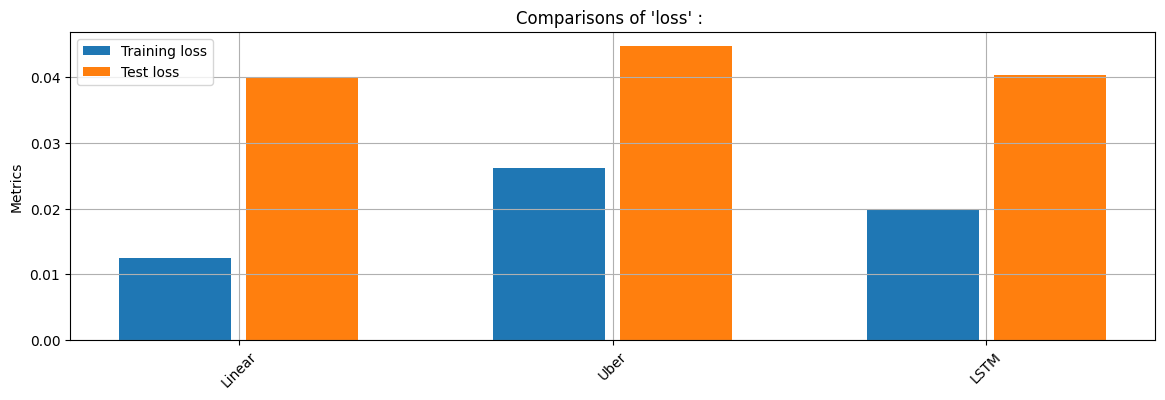

In [91]:
#%%script echo
for i, model in enumerate(models):
    print(f"Now Compiling model: {model.name} => {i+1}/{len(models)} models")
    history = ts_utils.compile_fit(model, window_trn, window_tst, epochs=50, patience=3, verbose=1)
    IPython.display.clear_output()

IPython.display.clear_output()
# Plot graphs
#performance={}
performance = ts_plot_utils.plot_performance(models, window_trn100, window_tst100, performance=performance, reeval=1)

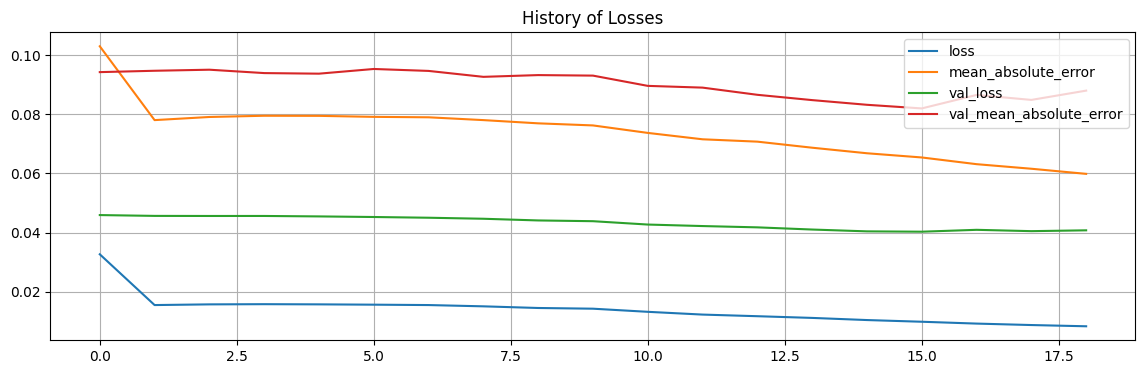

In [85]:
IPython.display.clear_output()

for l in history.history:
    plt.plot(history.history[l], label=f"{l}")
plt.title("History of Losses")
plt.legend()

### Anomaly Score - precision/Recall etc.

In [86]:
model     = models[0]
trn_errdf = None
tst_errdf = None

def getErrDF(model, window_trn, retdf=None, columns=None):
    for w in window_trn:
        p = model.predict(w[0])
        r = w[1] - p.reshape(w[1].shape)
        r.numpy().sum(axis=1)
        df=pd.DataFrame(r[:,-1], columns=columns) 
        
        if (retdf is None):
            retdf = df
        else:
            retdf.append(df, ignore_index=1)

    return retdf

trn_errdf = getErrDF (model, window_trn100, trn_errdf, df_scaled_trn.columns)
tst_errdf = getErrDF (model, window_tst100, tst_errdf, df_scaled_trn.columns)

115/115 [==============================] - 0s 1ms/step


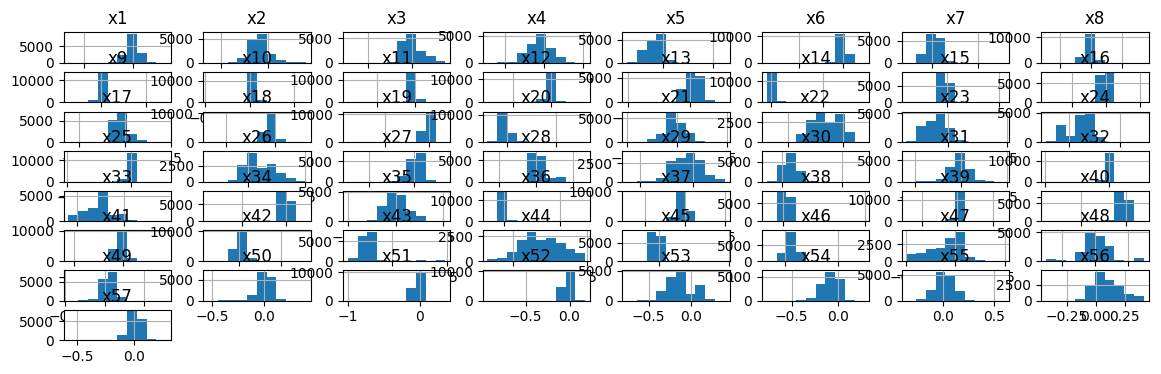

In [87]:
trn_errdf.hist();